# Hierarichal Clustering dari Hasil Topic Modelling

## Persiapan Data

### Melakukan import libraries

Lakukan import libraries yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np

#LDA Model
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint

#SKLearn Library
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

### Melakukan Load Data

**Mengambil Data Tweets periode Sebelum dan Setelah COVID-19**

Lakukan load data tweets dari file CSV di folder Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lakukan import file data tweets dari file CSV di folder Google Drive

Membaca data Tweets

In [3]:
#load data tweets
#tweets_df = pd.read_csv('../data/wordcloud/noncovid/final result/1_final_result_152432.csv')

#tambahan
tweets_df = pd.read_csv('/content/drive/MyDrive/Thesis/output/4_07022022_noncovid_ekstraksi_variabel_perilaku.csv')
#tweets_df = pd.read_csv('/content/drive/MyDrive/Thesis/output/4_07022022_covid_ekstraksi_variabel_perilaku.csv')

## Pemodelan LDA

### Pemrosesan Model LDA

Mempersiapkan data input untuk LDA Model

In [4]:
#copy data tweet
list_data = tweets_df.copy()

#membersihkan word character yang mengganggu proses pemodelan dan menyesuaikan format data input ke model LDA
list_data['tweet_tokens_final'] = list_data['tweet_tokens_final'].str.replace("'","")
list_data['tweet_tokens_final'] = list_data['tweet_tokens_final'].str.replace(",","")
list_data['tweet_tokens_final'] = list_data.tweet_tokens_final.apply(lambda x: x[1:-1].split(' '))

#copy data yang spesifik ke kolom 'tweet_tokens_final'
data_input = list_data['tweet_tokens_final']

Mempersiapkan dictionary untuk LDA Model

In [5]:
# membuat term dictionary dari korpus kita, dimana setiap kata unik akan diberikan sebuah index
id2word = corpora.Dictionary(data_input)
# buang term yang:
# 1. muncul di kurang dari 2 dokumen
# 2. muncul di lebih dari 0.9*(total_dok) dokumen
id2word.filter_extremes(no_below=2, no_above=0.9)
#menyalin data text twitter
texts = data_input
# ubah dictionary menjadi object bag-of-words reference
# ingat bahwa dalama LDA, dokumen diasumsikan dengan bag-of-words model
corpus = [id2word.doc2bow(text) for text in texts]

Melakukan load data LDA Model yang sudah didapatkan sebelumnya

In [6]:
lda_model = LdaModel.load('/content/drive/MyDrive/Thesis/Model/Topic Modeling/07022022_28_topic_before_covid_lda.model')
#lda_model = LdaModel.load('/content/drive/MyDrive/Thesis/Model/Topic Modeling/07022022_32_topic_after_covid_lda.model')

### Penentuan Topik setiap tweets berdasarkan Hasil Topic Modelling

Menemukan dominan topik pada setiap tweets

In [7]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_input):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_input)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

Menyimpan file 'df_dominan_topic' ke file CSV

In [11]:
df_dominant_topic.to_csv('/content/drive/MyDrive/Thesis/output/3_07022022_matching_28_topic_before_covid.csv')
#df_dominant_topic.to_csv('/content/drive/MyDrive/Thesis/output/3_07022022_matching_32_topic_before_covid.csv')

Load data hasil penentuan topic detiap tweets

In [12]:
df_dominant_topic = pd.read_csv('/content/drive/MyDrive/Thesis/output/3_07022022_matching_28_topic_before_covid.csv')
#df_dominant_topic = pd.read_csv('/content/drive/MyDrive/Thesis/output/3_07022022_matching_32_topic_before_covid.csv')

Menampilkan data hasil penentuan topik setiap tweets

In [13]:
#menghapus column index yang tidak penting
df_dominant_topic = df_dominant_topic.loc[:, ~df_dominant_topic.columns.str.contains('^Unnamed')]

#menghapus column Document_No
df_dominant_topic = df_dominant_topic.drop(['Document_No'], axis = 1)

# convert 'Dominant_Topic' dari tipe float ke tipe int
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)

#menampilkan sample data
df_dominant_topic.head(5)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1,0.7806,"kampung, sepi, minggu, sangka, kuota, parkir, ...","['minggu', '', 'lupa']"
1,15,0.2476,"libur, doa, maghrib, andai, atm, saran, telpon...","['shell', '', 'harga', '', 'kosong', '', 'moto..."
2,7,0.5513,"indonesia, motor, harga, tugas, lebih baik, su...","['tumbang', '', 'air', '', 'air', '', 'tenggel..."
3,13,0.7154,"gila, sekolah, tetangga, sampah, plastik, halt...","['terkadang', '', 'selesai', '', 'kecuali', ''..."
4,27,0.3939,"video, polisi, bahagia, pasar, korea, temenku,...","['', 'all', '', 'area']"


In [14]:
tweets_df['topic_predict'] = df_dominant_topic['Dominant_Topic']
tweets_df.to_csv('/content/drive/MyDrive/Thesis/output/4_07022022_noncovid_ekstraksi_variabel_perilaku.csv')
#tweets_df.to_csv('/content/drive/MyDrive/Thesis/output/4_07022022_covid_ekstraksi_variabel_perilaku.csv')

Melihat jumlah variasi topic

In [17]:
df_dominant_topic['Dominant_Topic'].unique()

array([ 1, 15,  7, 13, 27, 25, 18, 24,  3,  2, 16,  5,  9,  8,  0, 17, 26,
       22,  6, 23, 21, 19, 12, 14, 11, 10,  4, 20])

### Mereduksi Data berdasarkan kesesuaian Tweet dengan Topik tertentu

Mengambil 100 kata detiap topik berdasrakan nilai probabilitas tertinggi ke terendah

In [20]:
top_100_topic_words = lda_model.show_topics(num_topics=28, num_words=50, log=False, formatted=False)

Menampilkan kata per-topik untuk mempemudah proses pemilihan kata

In [45]:
for j in range(0, 5):
    dt = []
    for i in range(0, len(top_100_topic_words[j][1])):
        dt.append(top_100_topic_words[j][1][i][0])

    print(dt)
    print(' ')

['makan', 'belanja', 'followers', 'salah satu', 'swalayan', 'musnah', 'kenyang', 'jambu', 'jus', 'resto', 'bincang', 'buru buru', 'rakus', 'next time', 'gosong', 'enggak usah', 'petinggi', 'jangan lupa sholat']
 
['kuota', 'grabfood', 'boba', 'instagram', 'timeline', 'sulap', 'sold out', 'gagal', 'megah', 'minum obat', 'poster', 'jackpot', 'indosiar', 'desta', 'wajib militer']
 
['rezeki', 'kost', 'reaksi', 'renang', 'mahasiswa', 'segera mungkin', 'tiket pesawat', 'umbar', 'sebel', 'minum keras', 'gerbong', 'tanggal cantik', 'kolam renang']
 
['banjir', 'lapor', 'hotel', 'enggak apa', 'kuda', 'enggak tau', 'bohong', 'sungai', 'politik', 'koreksi', 'kamar mandi', 'surabaya', 'hutang', 'stay safe', 'rendam', 'sukarela']
 
['uang', 'mahal', 'sehat', 'tetap semangat', 'market', 'organ', 'realistis', 'suap', 'produk', 'graduate', 'laporin', 'sunda', 'umroh', 'fd', 'pose', 'lemes', 'simpul', 'medsos']
 


Melakukan load data stopwords untuk menghilangkan kata yang tidak berhubungan dengan topik

In [46]:
txt_stopword = pd.read_csv("/content/drive/MyDrive/Thesis/resources/stopwords/topic-stopwords.txt", names= ["stopwords"], header=None)
stopword = txt_stopword["stopwords"][0].split(' ')

Mengubah list ke bentuk dictionary

In [47]:
#merubah ke bentuk dictionary
topic_dict = dict(top_100_topic_words)

Menghapus kata yang tidak sesuai dengan topik menggunakan stopwords

In [48]:
#menghapus kata yang dianggap tidak sesuai
for i in range(0, len(topic_dict)):
    for j in range(0, len(topic_dict[i])):
        for word in stopword:
            try:
                if word == topic_dict[i][j][0]:
                    del topic_dict[i][j]
            except:
                pass

Melakukan import dan load data dictionary ke file *.pkl

In [49]:
import pickle

#dict_file = open('../data/wordcloud/noncovid/final result/new_230620211_matching_74_topic.pkl', "wb")
#pickle.dump(topic_dict, dict_file)
#dict_file.close()

In [ ]:
#dict_file = open('../data/wordcloud/noncovid/final result/new_230620211_matching_74_topic.pkl', 'rb')
#topic_dict = pickle.load(dict_file)
#dict_file.close()
#topic_dict

Memilih 20 kata dengan nilai probabibilitas tertinggi pada setiap topik

In [50]:
#memilih 20 kata setiap topic
for i in range(0, len(topic_dict)):
    for j in range(0, len(topic_dict[i])):
        for word in range (20, len(topic_dict[i])):
            try:
                del topic_dict[i][word]
            except:
                pass

In [51]:
list_data['topic_predict'] = df_dominant_topic['Dominant_Topic']
list_data['topic_perc_contrib'] = df_dominant_topic['Topic_Perc_Contrib']
list_data['topic_predict'] = list_data['topic_predict'].astype(int)

In [52]:
#menyimpan kata ke bentuk list
top_20_topics_words = []

for i in range(0, len(topic_dict)):
    for j in range(0, len(topic_dict[i])):
        top_20_topics_words.append(topic_dict[i][j][0])

In [53]:
#menghapus kata yang dianggap tidak sesuai

final_topics_words = []

for i in range(0, len(top_20_topics_words)):
  
    word_length = top_20_topics_words[i].split()
    
    if len(word_length)> 1:
      for j in range(0, len(word_length)):
        try:
            if word_length[j] not in  stopword:
              final_topics_words.append(word_length[j])
        except:
            pass
    else:
      try:
          if word_length not in  stopword:
              final_topics_words.append(word_length)
      except:
          pass

In [60]:
type(final_topics_words)

list

In [61]:
#seleksi tweet yang memiliki persentase kesesuaian topik besar 
selected_tweet = []

for i, row in list_data.iterrows():
    word_length = len(row['tweet_tokens_final'])
    similar_word_count = 0
    minimum_similarity_percentage = 60 #in percent
    
    for word in row['tweet_tokens_final']:
        if word in final_topics_words:
            similar_word_count = similar_word_count + 1

        percentage = round((similar_word_count/word_length)*100, 2)

    if percentage > minimum_similarity_percentage:
        selected_tweet.append(row)

In [62]:
len(final_topics_words)

387

Mengubah ke bentuk dataframe

In [63]:
selected_tweet_df = pd.DataFrame(selected_tweet, columns=list_data.columns)

In [64]:
len(selected_tweet_df)

47

In [65]:
selected_tweet_df['topic_predict'].unique()

array([16,  2,  8, 24, 15,  4,  6, 25])

### Pemodelan dengan Hierarichal Clustering

**Perisiapan Data Latih**

Menyiapkan data latih untuk proses training berdasarkan hasil dictionary topik pada proses sbeelumnya

In [ ]:
#membuat data latih untuk hierarical clustering berdasarkan top 20 topics
all_data = []

#perulangan untuk menggabungkan kata
for i in range(0, len(topic_dict)):
    #menggabungkan kata menjadi sebuah list
    words = []
    for j in range(0, len(topic_dict[i])):
        words.append(topic_dict[i][j][0])
    
    all_data.append([i, words])

Memilih data teks dari daftar topik untuk dijadikan data latih

In [ ]:
txt_data = []

#perulangan untuk mengambil daftar text dari setiap topik
for i in range(0, len(all_data)):
    txt_data.append([i, all_data[i][1]])
    
#konversi list ke bentuk dataframe
txt_data_df = pd.DataFrame(txt_data, columns=["topic_number", "words"])
txt_data_df['words'] = txt_data_df['words'].astype(str)

**Transformasi Data**

Melakukan seleksi fitur dengan pendekatan TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#deklarasi TF-IDF
tfidf_vectorizer = TfidfVectorizer()

#melakukan fit transform
tfidf_matrix = tfidf_vectorizer.fit_transform(txt_data_df['words']) #fit the vectorizer to synopses

#print dimensi matrix
print("TF-idf matrix: ",tfidf_matrix.shape)

#mengekstrak fitur
terms = tfidf_vectorizer.get_feature_names()

TF-idf matrix:  (74, 451)


Menghitung kesamaan kata menggunakan pendekatan cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#hitung cosine similarity
dist = 1 - cosine_similarity(tfidf_matrix)

#print hasil
print(dist)

[[ 0.00000000e+00  1.00000000e+00  8.97053982e-01 ...  0.00000000e+00
   0.00000000e+00  9.07490662e-01]
 [ 1.00000000e+00 -4.44089210e-16  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 8.97053982e-01  1.00000000e+00  0.00000000e+00 ...  8.97053982e-01
   8.97053982e-01  7.24644482e-01]
 ...
 [ 0.00000000e+00  1.00000000e+00  8.97053982e-01 ...  0.00000000e+00
   0.00000000e+00  9.07490662e-01]
 [ 0.00000000e+00  1.00000000e+00  8.97053982e-01 ...  0.00000000e+00
   0.00000000e+00  9.07490662e-01]
 [ 9.07490662e-01  1.00000000e+00  7.24644482e-01 ...  9.07490662e-01
   9.07490662e-01 -2.22044605e-16]]


**Pemodelan Data**

***1. Algoritma Agglomerative Clustering***

Melakukan proses pemodelan data dengan algoritma Agglomerative Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#pemodelan data dengan perulangan cluster 2-11
for i in range(2, 12):
    #pendekatakan jarak = euclidean, 
    #linkage = ward
    agg_dec = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    agg_model = agg_dec.fit(dist)
    
    #menghitung silhouette score
    silhouette_value = silhouette_score(dist, agg_dec.labels_, metric='euclidean')
    print("Silhouette Score ke-{}: ".format((i)), silhouette_value)

Silhouette Score ke-2:  0.7752793687853403
Silhouette Score ke-3:  0.4500004778576025
Silhouette Score ke-4:  0.4100631295743129
Silhouette Score ke-5:  0.4073322075833212
Silhouette Score ke-6:  0.3982948579852786
Silhouette Score ke-7:  0.38903762445736634
Silhouette Score ke-8:  0.387498302915503
Silhouette Score ke-9:  0.38775578339401007
Silhouette Score ke-10:  0.37189037935857366
Silhouette Score ke-11:  0.3731039078341185


***1. Algoritma K-Means***

Melakukan proses pemodelan data dengan algoritma K-Means

In [ ]:
from sklearn.cluster import KMeans

#pemodelan data dengan perulangan cluster 2-11
for i in range(2, 12):
    #pemodelan k-means
    km_desc = KMeans(n_clusters=i)
    km_model = km_desc.fit(dist)
    
    #menghitung silhouette score
    silhouette_value = silhouette_score(dist, km_model.labels_)
    print("Silhouette Score ke-{}: ".format((i)), silhouette_value)

Silhouette Score ke-2:  0.7752793687853403
Silhouette Score ke-3:  0.4433435594058288
Silhouette Score ke-4:  0.4140852717088252
Silhouette Score ke-5:  0.3964204642748162
Silhouette Score ke-6:  0.38436830559255847
Silhouette Score ke-7:  0.38369485861661584
Silhouette Score ke-8:  0.3650883945006532
Silhouette Score ke-9:  0.3702802455935436
Silhouette Score ke-10:  0.36938516437959157
Silhouette Score ke-11:  0.36797174699339763


**Kesimpulan**

Berdasarkan hasil pemodelan K-Means dan Agglomerative Clustering, Agglomerative Clustering memiliki hasil yang lebih baik. Jadi, untuk algoritma yang digunakan dalam clustering label adalah Agglomerative Clustering.
Kemudian nilai cluster di set = 5

In [ ]:
#membuat pemodelan dengan 5 cluster
final_model_desc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
final_model = final_model_desc.fit(dist)

#menghitung silhouette score
silhouette_value = silhouette_score(dist, final_model.labels_, metric='euclidean')
print("Silhouette Score ke-{}: ".format((i)), silhouette_value)

Silhouette Score ke-11:  0.4073322075833212


Menggabungkan hasil cluster dengan data topik

In [ ]:
from sklearn.externals import joblib

#deklarasi cluster
clusters = final_model.labels_.tolist()

#menggabungkan hasil cluster
cluster_result = { 'topic_number': list(txt_data_df['topic_number'].values), 'words': list(txt_data_df['words'].values), 'cluster': clusters }

#konvert ke dataframe
cluster_result_df = pd.DataFrame(cluster_result, index = [clusters] , columns = ['topic_number', 'words','cluster'])
cluster_result_df

,topic_number,words,cluster
3,0,"['watchlistku', 'genie', 'metong', 'kikir', 'd...",3
1,1,"['kantor', 'tetangga', 'musik', 'hadiah', 'tah...",1
0,2,"['milea', 'sheep', 'kst', 'familyma', 'lagoon'...",0
2,3,"['keluarga', 'stasiun', 'televisi', 'manjat', ...",2
3,4,"['watchlistku', 'genie', 'metong', 'kikir', 'd...",3
...,...,...,...
2,69,"['uang', 'salah', 'demo', 'masak', 'profesiona...",2
1,70,"['rakyat', 'antre', 'parkir', 'bank', 'kuota',...",1
3,71,"['watchlistku', 'genie', 'metong', 'kikir', 'd...",3
3,72,"['watchlistku', 'genie', 'metong', 'kikir', 'd...",3


**PLotting Data**

Melakukan plotting data berdasarkan ahsil clustering

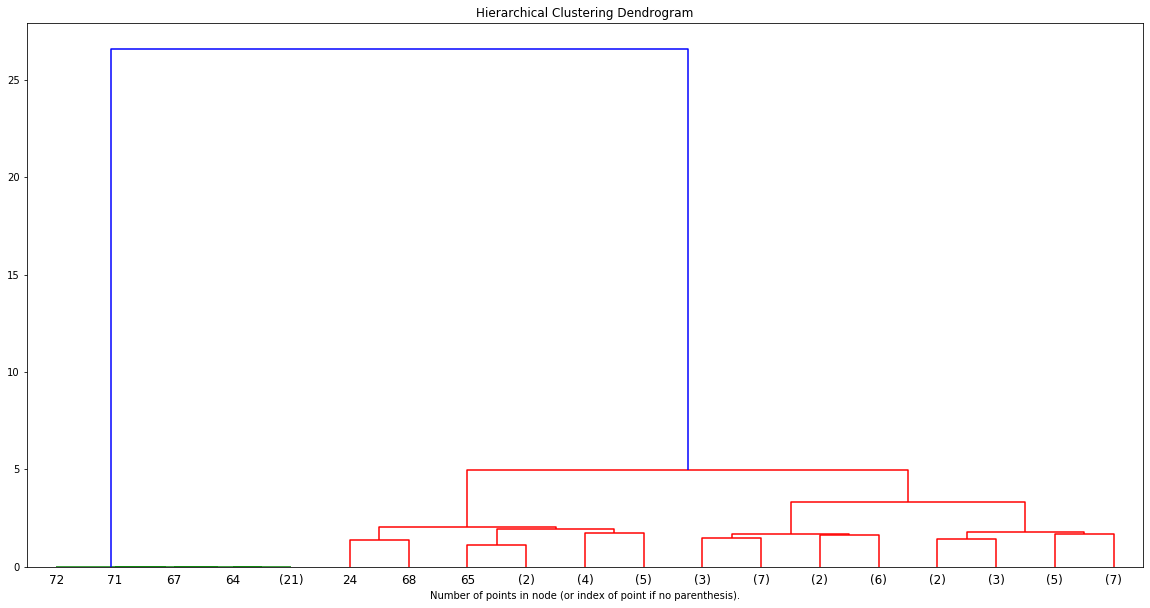

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.subplots(figsize=(20, 10))
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(dist)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Membuat plotting Data berdasarkan Dendogram

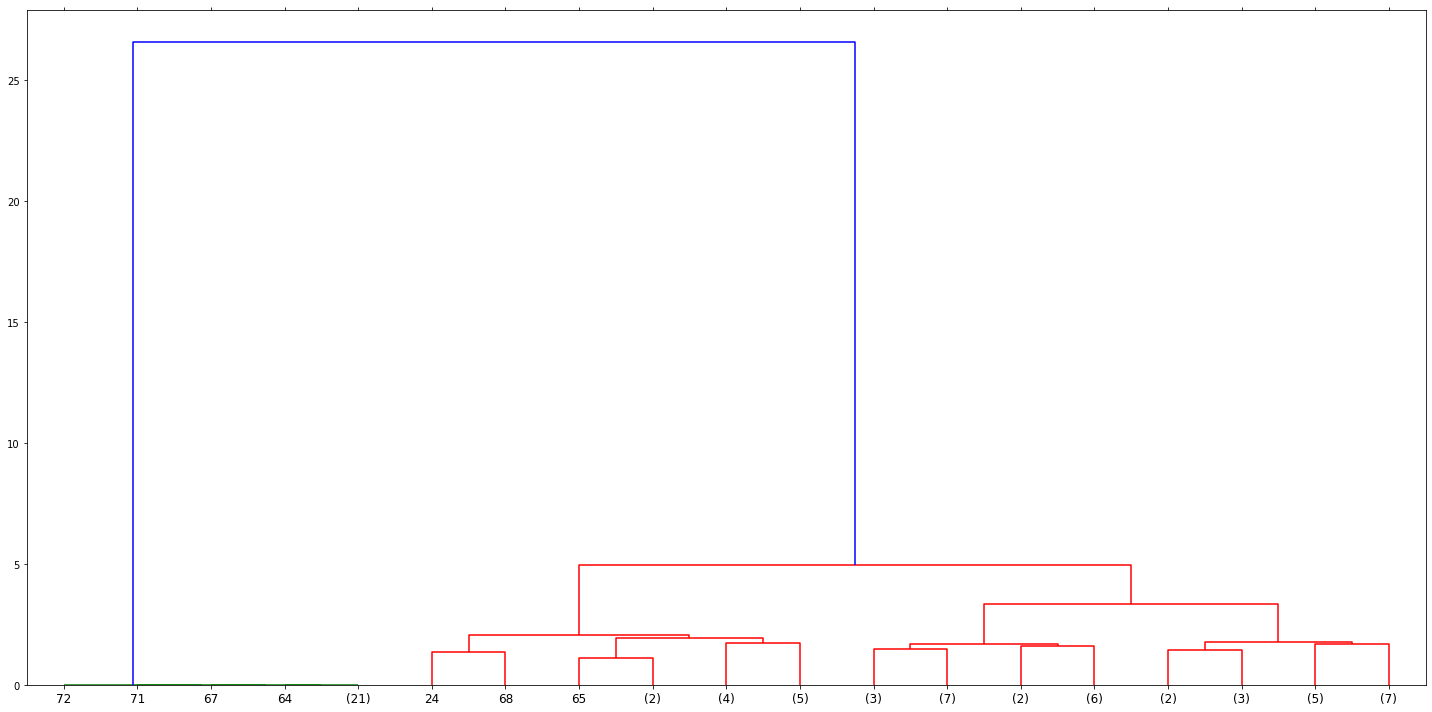

In [ ]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 10)) # set size
ax = dendrogram(linkage_matrix, orientation="top", 
                labels=list(txt_data_df['topic_number'].values), 
                truncate_mode='level', p=4);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

In [ ]:
#txt_data_df.to_csv('../data/wordcloud/noncovid/final result/txt_data_152432.csv')

### Penyesuaian Topik dengan Data Tweet

Deklarasi function untuk membuat cluster baru

In [ ]:
def create_new_cluster(tweets_df):
    new_cluster = []
    
    cluster_based = cluster_result_df['cluster'].unique()
    
    for i, row in tweets_df.iterrows():
        for j in cluster_based:
            based_data = cluster_result_df[cluster_result_df['cluster'] == j]
            list_topik_from_cluster = based_data['topic_number'].unique()
            #list_topik_from_cluster = str(list_topik_from_cluster).split(' ') 
            
            if row['topic_predict'] in list(list_topik_from_cluster):
                new_cluster.append(j)
    
    return new_cluster

Menggabungkan data hasil clustering dengan data tweet (keseluruhan data)

In [ ]:
hc_topic = []
hc_word = []

#perulangan data untuk menyimpan data cluster topik
for i, row in list_data.iterrows():
    topics = txt_data_df[txt_data_df['topic_number'] == row['topic_predict']]
    tp_data = topics['topic_number'].tolist()
    wp_data = topics['words'].tolist()
    hc_topic.append(tp_data[0])
    hc_word.append(wp_data[0])
    
#menambahkan data ke dataframe
list_data['hc_topic'] = hc_topic
list_data['hc_words'] = hc_word

Menambahkan kolom cluster pada data 'list_data'

In [ ]:
#memanggil fungsi create_new_cluster
cluster_list_data = create_new_cluster(list_data)

#menambahkan data
list_data['cluster'] = cluster_list_data

#menghilangkan kolom unamed
list_data = list_data.loc[:, ~list_data.columns.str.contains('^Unnamed')]

In [ ]:
#list_data.to_csv('../data/wordcloud/noncovid/final result/final_tweet_data.csv')

Menggabungkan data hasil clustering dengan data tweet (berdasarkan data yang sudah direduksi)

In [ ]:
#2500 topic
hc_topic = []
hc_word = []

#perulangan data untuk menyimpan data cluster topik
for i, row in selected_tweet_df.iterrows():
    topics = txt_data_df[txt_data_df['topic_number'] == row['topic_predict']]
    tp_data = topics['topic_number'].tolist()
    wp_data = topics['words'].tolist()
    hc_topic.append(tp_data[0])
    hc_word.append(wp_data[0])

#menambahkan data ke dataframe
selected_tweet_df['hc_topic'] = hc_topic
selected_tweet_df['hc_words'] = hc_word

In [ ]:
#memanggil fungsi create_new_cluster
cluster_list_data = create_new_cluster(selected_tweet_df)

#menambahkan data
selected_tweet_df['cluster'] = cluster_list_data

#menghilangkan kolom unamed
selected_tweet_df = selected_tweet_df.loc[:, ~selected_tweet_df.columns.str.contains('^Unnamed')]

In [ ]:
selected_tweet_df.to_csv('../data/wordcloud/noncovid/final result/final_selected_tweet_data.csv')